In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation
from functools import partial

class InvertedPendulum:
    def __init__(self, m, l, g, k) -> None:
        self.m, self.l, self.g, self.k = m, l, g, k

    def thetaDDot(self, Theta, Tau):
        return 1.5*self.g/self.l*np.sin(Theta) - Tau*3/self.m/self.l**2
    
    def DynSS(self, y, t,Tau):
        Theta, Omega = y
        dydt = [Omega, -1.5*self.g/self.l*np.sin(Theta) + 3*Tau/self.m/self.l**2 - 3*self.k*Omega/self.m/self.l**2]
        return dydt
    
    def nextState(self, y,Tau, Ts):
        y0 = y
        sol = odeint(self.DynSS, y0, [0, Ts], args=(Tau,))
        return sol[1,:]

def reward(Theta, ThetaTarget):
    return 1- np.cos(Theta)

def closestDiscInd(DiscArr, val):
    diff = np.absolute(DiscArr -val)
    Ind = np.argmin(diff)
    return Ind

def update(frame, theta_arr, pendCen, pendLen, line): #function for creating animation
    theta = theta_arr[frame]
    x = [pendCen[0], pendCen[0] - pendLen*np.sin(theta)]
    z = [pendCen[1], pendCen[1] - pendLen*np.cos(theta)]
    line.set_xdata(x)
    line.set_ydata(z)
    return line


In [2]:

def Q_learning(InvertedPendulum, QInit, ThetaTarget, Ts, ThetaRes, OmegaRes, res, TauDisc, OmegaRange, ThetaDisc, OmegaDisc, Gamma, pi,
                episodes = 150000, maxEpisodeLength = 800, eps = 0.1):
    Q = np.copy(QInit)
    
    for i in range(episodes):
        Theta = 0
        Omega = 0
        
        ThetaHist = [Theta]
        CritThetaCount = 0
        ThetaVisitCount = np.zeros(ThetaRes)
        
        for j in range(maxEpisodeLength):
            #First find the next state
            TauInd = np.random.randint(res) #generating a random action
            Tau = TauDisc[TauInd]
            #print('Theta: ', Theta, 'Omega: ', Omega, 'Tau: ', Tau)
            Theta_n, Omega_n = InvertedPendulum.nextState([Theta, Omega], Tau, Ts)
            if Theta_n >= 2*pi:
                Theta_n = Theta_n - 2*pi
            elif Theta_n < 0:
                Theta_n = Theta_n + 2*pi
            ThetaHist.append(Theta_n)
            #print('Theta_n: ', Theta_n)
            if Omega_n > OmegaRange:
                #print('Omega exceeding the bounds, stopping learning')
                break

            #Update the Q function
            #First find the closest Theta value in the discretized theta to the current Theta and Theta_n
            
            ThetaInd = closestDiscInd(ThetaDisc, Theta)
            Theta_nInd = closestDiscInd(ThetaDisc, Theta_n)
            OmegaInd = closestDiscInd(OmegaDisc, Omega)
            Omega_nInd = closestDiscInd(OmegaDisc, Omega_n)
            Q_new = np.copy(Q)
            f_term = Q[ThetaInd, OmegaInd, TauInd]
            s_term = reward(ThetaDisc[ThetaInd],  ThetaTarget) + Gamma*Q[Theta_nInd, Omega_nInd, :].max()

            Q_new[ThetaInd, OmegaInd, TauInd] = (1-eps)*f_term + eps*s_term

            Theta, Omega = ThetaDisc[Theta_nInd], OmegaDisc[Omega_nInd]
            Q = np.copy(Q_new)

    return Q_new, ThetaHist

In [3]:
def simulate(InvertedPendulum,Q, ThetaDisc,OmegaDisc, TauDisc, Theta0, Omega0, simIter, Ts, pi):
    Theta, Omega = Theta0, Omega0
    ThetaSim = [Theta]
    TauSim = []
    for i in range(simIter):
            
        ThetaInd = closestDiscInd(ThetaDisc, Theta)
        OmegaInd = closestDiscInd(OmegaDisc, Omega)
        #Finding optimal action for the current state

        optTauInd = np.argmax(Q[ThetaInd, OmegaInd,:])
        optTau = TauDisc[optTauInd]
        TauSim.append(optTau)
        Theta_n, Omega_n = InvertedPendulum.nextState([Theta, Omega], optTau, Ts)
        if Theta_n >= 2*pi:
            Theta_n = Theta_n - 2*pi
        elif Theta_n < 0:
            Theta_n = Theta_n + 2*pi
        ThetaSim.append(Theta_n)
        Theta, Omega = Theta_n, Omega_n
    return ThetaSim, TauSim



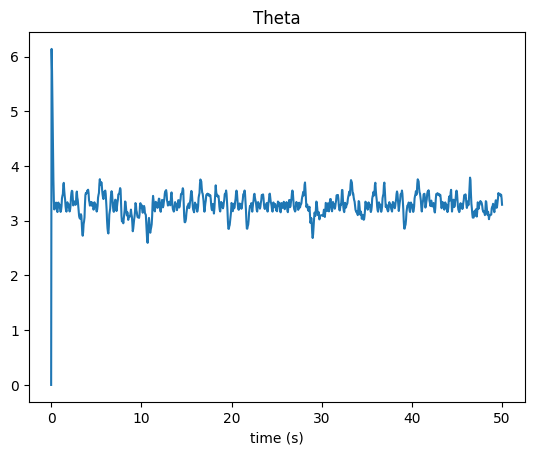

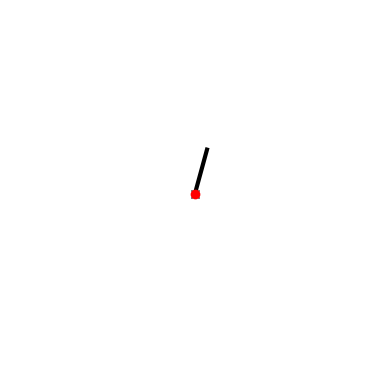

In [4]:
def main():
    g = 9.80665 #acceleration due to gravity
    m = 1    #mass of the bar
    l = 0.5      #length of the bar
    pi = 3.1415926535
    Gamma = 0.9 #Discount factor

    TauRange = 2*m*g*l  #max torque is twice of what is required to balances the mass in 90 degree configuration 

    res = 9  #resolution of the control input or the totan number of discretized values of the control inpput. This value should ne odd number

    ThetaRes = 101 #resolution of theta : creating the discrete state from the originally continuous state theta
                    #Odd number in the resolution will ensure that the theta for the vertically up position is included in the discrete state

    OmegaRes = 101

    OmegaRange = 14

    OmegaDisc = np.linspace(-OmegaRange, OmegaRange, OmegaRes)
    Ts = 0.05 #50 ms sample time

    k = 0.1 #damping constant

    ThetaTarget = pi #Angle at which we intend to stabilize

    ThetaDisc = np.linspace(0, 2*pi, ThetaRes)
    TauDisc = np.linspace(-TauRange, TauRange, res)

    InvPend = InvertedPendulum(m,l,g,k)

    Q_new = np.zeros((ThetaRes, OmegaRes, res))

    QOpt, ThetaHist = Q_learning(InvPend, Q_new, ThetaTarget, Ts, ThetaRes, OmegaRes, res, TauDisc, OmegaRange, ThetaDisc, OmegaDisc, Gamma,pi)

    # Controling pendulum using the learned Q-function
    Theta0 = 0
    Omega0 = 0
    simIter = 1000
    time = np.arange(0, (simIter+1)*Ts, Ts)
    ThetaSim, TauSim = simulate(InvPend,QOpt, ThetaDisc,OmegaDisc, TauDisc, Theta0, Omega0, simIter, Ts, pi)

    plt.figure(1)
    plt.plot(time, ThetaSim)
    plt.title('Theta')
    plt.xlabel('time (s)')

    #creating animation
    fig, ax = plt.subplots()
    pendCent = [2,2]
    offset = [-l*np.sin(Theta0), -l*np.cos(Theta0)]
    pendEnd = pendCent + offset

    line = ax.plot([pendCent[0], pendEnd[0]], [pendCent[1], pendEnd[1]], 'k-', linewidth=3)[0]
    ax.plot(pendCent[0], pendCent[1], 'kx')
    ax.plot(pendEnd[0], pendEnd[1], 'ro')
    ax.set(xlim = [0,4], ylim = [0,4], xlabel = "x", ylabel = "z")
    plt.gca().set_aspect('equal')
    plt.axis('off')
    ani = animation.FuncAnimation(fig=fig, func=partial(update, theta_arr = ThetaSim, pendCen = pendCent, pendLen = l, line = line), frames=simIter, interval = int(Ts*1000))
    #writervideo = animation.FFMpegWriter(fps=60) 
    ani.save('Invpend_QLearn.gif')#, writer=writervideo) 
    plt.close
    
    
if __name__ == '__main__':
    main()